In [1]:
class AutoRangingDetector(object):
##    def __init__(self, rows, cols, nRanges, cameraType=None):
    def __init__(self, rows, cols, cameraType=None, cameraConfig=None):
##    def __init__(self, rows, cols, switchPoints, switchWidths, offsets, gainUncertainty, I0width, flatField, cameraType="JF"):
        self.rows = rows
        self.cols = cols
        self.cameraType = cameraType
        self.cameraConfig = cameraConfig

        cameraTypes = ["JF", "ePix10k", "ePix10kTender"]
        if self.cameraType not in cameraTypes:
            print "'%s' not in recognized cameras" %(cameraType), cameraTypes
            raise
        cameraConfigs = [None, 
                         "highLow", "mediumLow", ## autoranging ePix10k
                         "fixedHigh", "fixedMedium", "fixedLow"] ## fixed
        if cameraConfig not in cameraConfigs:
            print "'%s' not in recognized camera configs" %(cameraConfig), cameraConfigs
            raise
        if self.cameraType == "JF":
            self.nBits = 14
            self.maxEnergy = 15000*8 ##keV
            self.nRanges = 3
            self.switchPoints = [40*8, 1500*8, self.maxEnergy*666] ## keV
            self.switchPointVariations = [1.*8, 10.*8, 0.] ## keV, placeholder
            self.switchPointWidths = [1.*8, 10.*8, 0.] ## keV, placeholder
            self.offsets = [0, 2100, 1900] ## ADU; placeholder
            self.gains = [40., 1., 0.1] ## ADU/keV
            self.gainErrors = [0.01, 0.015, 0.02] ## dimensionless, placeholder
            self.nonLinearity = [0.01/320, 0.015/12000, 0.017/self.maxEnergy] ## 1/keV, placeholder
        elif 'ePix10k' in self.cameraType:
            self.nBits = 14
            self.maxEnergy = 10000*8 ##keV
            self.nRanges = 2
            if self.cameraConfig in ["mediumLow", "fixedMedium", "fixedLow"]:
                self.switchPoints = [300*8, self.maxEnergy*666] ## keV
                if self.cameraConfig == "fixedMedium":
                    tmp = self.switchPoints[0]
                    self.switchPoints[0] = self.maxEnergy*666
                    self.maxEnergy = tmp
                if self.cameraConfig == "fixedLow":
##                    pass
                    self.switchPoints[0] = -666
                self.switchPointVariations = [4.*8, 0.] ## keV, placeholder
                self.switchPointWidths = [4.*8, 0.] ## keV, placeholder
                self.offsets = [0, 2100] ## ADU; placeholder
                self.gains = [4.1, 0.1] ## ADU/keV
                self.gainErrors = [0.01, 0.015] ## dimensionless, placeholder
                self.nonLinearity = [0.01/2400, 0.017/self.maxEnergy] ## 1/keV, placeholder
            else:
                self.switchPoints = [100*8, self.maxEnergy*666] ## keV
                if self.cameraConfig == "fixedHigh":
                    tmp = self.switchPoints[0]
                    self.switchPoints[0] = self.maxEnergy*666
                    self.maxEnergy = tmp
                self.switchPointVariations = [2.*8, 0.] ## keV, placeholder
                self.switchPointWidths = [2.*8, 0.] ## keV, placeholder
                self.offsets = [0, 1100] ## ADU; placeholder
                self.gains = [12.5, 0.1] ## ADU/keV
                self.gainErrors = [0.01, 0.015] ## dimensionless, placeholder
                self.nonLinearity = [0.01/800, 0.017/self.maxEnergy] ## 1/keV, placeholder
        else:
            print self.cameraType, cameraTypes
            raise Exception

        self.minE = [0.] + self.switchPoints[0:self.nRanges-1] ## keV
        ## this is for adding nonlinearity
        ## calculated with respect to start of range
        self.nonLinearity = np.array(self.nonLinearity)
        self.nonLinearity *= 0. ## comment out to get nonlinearity
##        self.nonLinearity = [0, 0]

        self.setupMatrices()
        ## the idea is to allow us to use a scalar to describe the 2d array
        ## corresponding to a particular characteristic
        ## or to smear a 2d array
        ## or one might use a numpy array to set the 2d array

    def updateFlatGains(self, flatGains):  ## not sure this makes sense in the residual world
        self.gains = self.matricize(flatGains)
        raise Exception

##    def updateGains(self, gains):
##        self.gains = gains

    def updateFlatOffsets(self, flatOffsets):
        self.offsets = self.matricize(flatOffsets)

##    def updateOffsets(self, offsets):
##        self.offsets = offsets

    def updateFlatSwitchPoints(self, flatSwitchPoints):
        self.switchPoints = self.matricize(flatSwitchPoints)

    def updateSwitchPoints(self, switchPoints):
        self.switchPoints = switchPoints

    def setupMatrices(self):
##        np.save("a.npy", self.matricize(self.gains, self.gainErrors, None))
##        np.save("b.npy", self.matricize(self.gains, None, None))
##        raise Exception
        self.residualGains = self.matricize(self.gains, self.gainErrors, None)/self.matricize(self.gains, None, None)
        self.offsets = self.matricize(self.offsets)
        self.switchPoints = self.matricize(self.switchPoints, None, self.switchPointVariations)

    def matricize(self, array, relativeSmear=None, absoluteSmear=None):
        base = np.ones((self.rows, self.cols))
        tmp = []
        [tmp.append(array[i]*base) for i in range(self.nRanges)]
##        if relativeSmear is not None:
##            smears = 1 - np.random.random(self.nRanges*self.rows*self.cols).reshape((self.nRanges, self.rows, self.cols))*relativeSmear
##            tmp *= smears
        if relativeSmear is not None: ## should probably be by range, handle array or scalar
            if not np.isscalar(relativeSmear):
                print "temp check in relativeSmear array handler"
                if len(relativeSmear)==self.nRanges:
                    for n in range(self.nRanges): ## lazy and unidiomatic
                        smears = 1 + (np.random.normal(size=self.rows*self.cols).reshape((self.rows, self.cols))).clip(-3,3)*relativeSmear[n]
                        ## clip to eliminate unfortunate tails, e.g. negative gain 
                        tmp[n] *= smears
                else:
                    raise Exception
            else:
                smears = 1 + np.random.normal(size=self.nRanges*self.rows*self.cols).reshape((nRanges, self.rows, self.cols))*relativeSmear
                tmp += smears 
        if absoluteSmear is not None: ## should probably be by range, handle array or scalar
            if not np.isscalar(absoluteSmear):
                print "temp check in absoluteSmear array handler"
                if len(absoluteSmear)==self.nRanges:
                    for n in range(self.nRanges): ## lazy and unidiomatic
                        smears = (np.random.random(self.rows*self.cols).reshape((self.rows, self.cols))-0.5)*absoluteSmear[n] ## shifts 0, 1 to -0.5, 0.5 and scales
                        tmp[n] += smears
                else:
                    raise Exception
            else:
                smears = (np.random.random(self.nRanges*self.rows*self.cols).reshape((nRanges, self.rows, self.cols))-0.5)*absoluteSmear ## shifts 0, 1 to -0.5, 0.5 and scales
                tmp += smears
        return np.array(tmp)

    def setGains(self, gains):
        if gains.shape != (self.nRanges, self.rows, self.cols):
            print "gain problem,", gains.shape, "!=", (self.rows, self.cols)
            raise
        self.gains = gains

    def setOffsets(self, offsets):
        print "foo", 1/0

In [2]:
class BuildAutoRangeFrames(object):
    def __init__(self, detector, I0width, I0min=0, I0max=300000, flatField=None):
        self.det = detector
        self.rows = self.det.rows
        self.cols = self.det.cols
        self.frame = np.zeros((self.rows, self.cols))
        self.gainBits = np.zeros((self.rows, self.cols), dtype=int)
        
        self.I0max = I0max
        self.I0min = I0min
        self.I0saturated = 250000
        self.I0width = I0width

        self.flatField = flatField

        self.twoTo14 = 2**14

    def getTrueI0(self):
        self.trueI0 = np.random.random()*(self.I0max-self.I0min) + self.I0min

    def getI0(self):
        self.getTrueI0()
        if self.trueI0 > self.I0saturated:
            return self.I0saturated
        self.I0 = self.trueI0 * (1.+(np.random.random()-0.5)*self.I0width)
    
    def makeFrame(self):
        self.getI0()
        for i in range(self.rows):
            for j in range(self.cols):
                if False:
                    print self.trueI0
                    print self.flatField[i, j]
                energy = self.trueI0 * self.flatField[i, j]
                detectorFried = True
                for k in range(self.det.nRanges):
##                    print "tmp", flux, self.det.switchPoints[k, i, j], self.det.switchPointWidths[k]*np.random.normal()
                    if energy < (self.det.switchPoints[k, i, j] + self.det.switchPointWidths[k]*np.random.normal()):
                        detectorFried = False
                        break
                if detectorFried or False:##True:
                    print energy
                    print self.det.gains[k, i, j]
                    print self.det.offsets[k, i, j]
                    if detectorFried:
                        print "flux in pixel exceeds limit, giving up"
                        raise Exception
                nonLinearity = (energy-self.det.minE[k])**2*self.det.nonLinearity[k] ## didn't bother to matricize this
                self.frame[i, j] = np.min((self.det.maxEnergy, energy*self.det.residualGains[k, i, j]+self.det.offsets[k, i, j]+nonLinearity))
                self.gainBits[i, j] = k

    def getFrame(self):
        return self.frame

    def getGainBits(self):
        return self.gainBits

In [3]:
%matplotlib inline

temp check in relativeSmear array handler
temp check in absoluteSmear array handler
bauf stuff
75005.9506221
[[  76421.76393462   76253.78857098   76984.36657647 ...,   76882.23322889
    76701.63031357   75870.15376106]
 [  76091.85183901   75016.631343     75143.71460564 ...,   74580.14376765
    75482.39375654   75023.46508706]
 [  76865.5948256    77277.63084536   73258.89339994 ...,   73161.04837759
    75473.61864193   74244.1271382 ]
 ..., 
 [  76606.42218192   74039.29687261   75289.66496139 ..., -422850.86536877
  -429496.43755752 -430734.97473844]
 [  75311.43370486   76162.3632828    72493.26963612 ..., -431504.87317665
  -427004.6857142  -434898.10729356]
 [  76143.10791095   73914.44019444   74933.35182436 ..., -433176.46070284
  -428459.49389387 -425437.89451587]]
(352, 384)
(16, 352, 384)
calib [[[10885 10717 11448 ..., 11346 11165 10334]
  [10555  9480  9607 ...,  9044  9946  9487]
  [11329 11741  7722 ...,  7625  9937  8708]
  ..., 
  [11070  8503  9753 ..., 35902 2925

[D] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
[D] findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
[D] findfont: Matching :family=STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeOneSym (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf') with score of 0.050000
[D] findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGenera

median, spread: 33203.0 18477.0


[D] findfont: Matching :family=cmex10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmex10 (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf') with score of 0.050000
[D] findfont: Matching :family=cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmsy10 (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf') with score of 0.050000
[D] findfont: Matching :family=cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmr10 (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf') with score of 0.050000
[D] findfont: Matching :family=cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmss10 (u'/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4

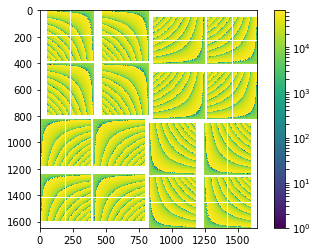

In [4]:
import psana
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(levelname).1s] %(message)s', level=logging.DEBUG)
from Detector.UtilsEpix10ka import find_gain_mode
from Detector.GlobalUtils import print_ndarr

experimentName = 'xcsx35617'
runNumber = '421' ## low-gain dark run --> FL
detName = 'epix10ka2m'
ds = psana.DataSource('exp='+experimentName+':run='+runNumber+':idx')
run = ds.runs().next()
det = psana.Detector(detName)
times = run.times()

env = ds.env()
peds = None
mask = None
gain = None

rows = 352
cols = 384
det_autoranging = AutoRangingDetector(rows, cols, "ePix10k")
if False:
    print "residual gains"
    print det_autoranging.residualGains
    print det_autoranging.residualGains.mean(), det_autoranging.residualGains.std()

I0width = 0.03
flatField = np.ones((rows, cols))
for i in range(rows):
    for j in range(cols):
        flatField[i, j] -= i*j/20000.
        
bauf = BuildAutoRangeFrames(det_autoranging, I0width, 0, 150000, flatField)

for enum, i in enumerate(times):
    if enum > 2: break
    
    bauf.makeFrame()
    if True:##False:
        print "bauf stuff"
        print bauf.I0
        print bauf.frame
        print bauf.frame.shape
        calib = np.tile(bauf.frame, (16,1)).reshape((16, 352, 384)).astype('uint16')
        print calib.shape
        calib = calib.astype('uint16')
        print 'calib', calib
                
    evt = run.event(i)
    raw = det.raw(evt)
    if raw is None:
        continue
    if peds is None:
        peds = det.pedestals(evt)[2].astype(np.uint16)
        print_ndarr(peds, 'peds')
    if mask is None:
        mask = det.status_as_mask(evt)
        print_ndarr(mask, 'mask')
    if gain is None:
        gain = det.gain(evt)[2]
        print_ndarr(gain, 'gain')
    img = det.image(evt, calib)
    med = np.median(calib)
    spr = np.median(np.abs(calib-med))
    print 'median, spread:', med, spr
    plt.imshow(img, norm=LogNorm())
    plt.colorbar()
    plt.show()
    break